<a href="https://www.kaggle.com/code/mehranommani/car-price?scriptVersionId=198824308" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


In [2]:
import pandas as pd

# Load the datasets
train = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')

   id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2                             A/T  

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


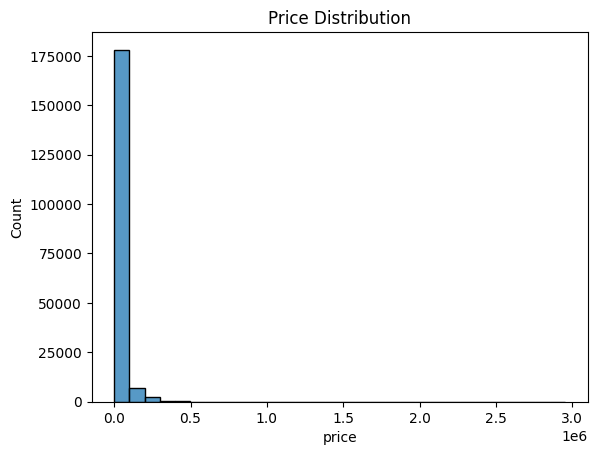

In [3]:
# Visualizations can include histograms, box plots, etc.
import matplotlib.pyplot as plt
import seaborn as sns

# Display first few rows of the dataset
print(train.head())

# Check for missing values
print(train.isnull().sum())
sns.histplot(train['price'], bins=30)
plt.title('Price Distribution')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


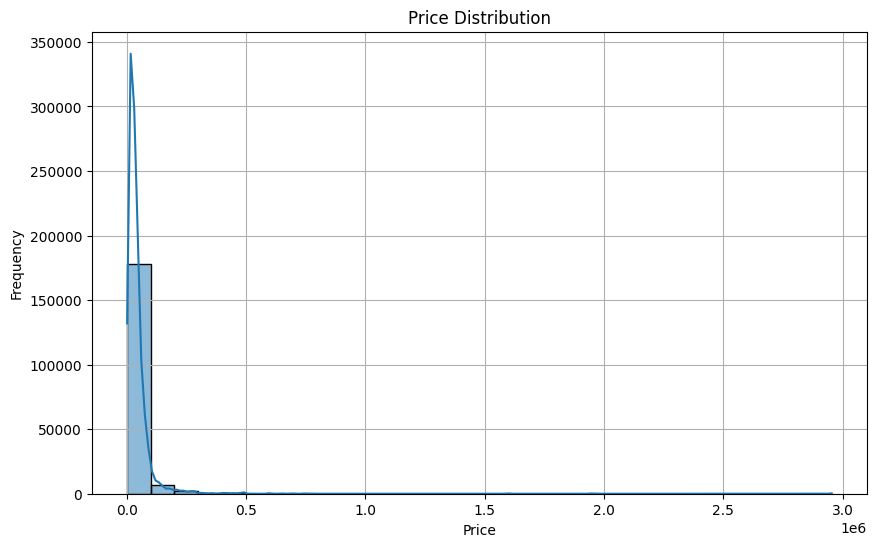

In [4]:
# Plotting the distribution of the price
plt.figure(figsize=(10, 6))
sns.histplot(train['price'], bins=30, kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [5]:
import pandas as pd
import numpy as np
import re

# Define a function for all preprocessing steps

def preprocess_data(df):
    # Step 1: Convert fuel_type to numeric using Label Encoding
    df['fuel_type'] = df['fuel_type'].astype('category').cat.codes

    # Step 2: Extract numeric values from the `engine` column
    def extract_engine_features(engine_str):
        hp = float(re.search(r'(\d+\.?\d*)HP', engine_str).group(1)) if re.search(r'(\d+\.?\d*)HP', engine_str) else np.nan
        size = float(re.search(r'(\d+\.?\d*)L', engine_str).group(1)) if re.search(r'(\d+\.?\d*)L', engine_str) else np.nan
        cylinders = int(re.search(r'(\d+) Cylinder', engine_str).group(1)) if re.search(r'(\d+) Cylinder', engine_str) else np.nan
        
        return pd.Series([hp, size, cylinders])

    # Apply the function to extract features
    df[['engine_hp', 'engine_size', 'engine_cylinders']] = df['engine'].apply(extract_engine_features)

    # Step 3: Drop the original engine column
    df.drop(columns=['engine'], inplace=True)

    # Step 4: Function to classify and encode transmission type
    def encode_transmission(trans):
        if any(x in trans for x in ['A/T', 'Automatic', 'CVT', 'DCT']):
            return 2  # Automatic
        elif any(x in trans for x in ['M/T', 'Manual']):
            return 1  # Manual
        else:
            return 0  # Other

    # Step 5: Function to extract gear speed
    def extract_gears(trans):
        if trans in ['A/T', 'Automatic', 'CVT', 'DCT']:
            return 2
        match = re.search(r'(\d+)-Speed|(\d+)', trans)
        if match:
            return int(match.group(1) or match.group(2))
        return np.nan

    # Step 6: Apply the functions to the DataFrame
    df['gear_speed'] = df['transmission'].apply(extract_gears)
    df['transmission'] = df['transmission'].apply(encode_transmission)


    # Step 7: Set NaN in gear_speed to 0
    df['gear_speed'].fillna(0, inplace=True)

    # Step 8: Drop rows where gear_speed is 0
    df = df[df['gear_speed'] != 0]

    # Step 10: Map values in the 'accident' column to numeric values
    mapping = {
        'None reported': 0,
        'At least 1 accident or damage reported': 1
    }

    df['accident'] = df['accident'].map(mapping)

    # Step 11: Drop rows where 'accident' is NaN
    df = df.dropna(subset=['accident'])

    # Step 12: Fill missing values for numerical columns with the median
    df['engine_hp'] = df['engine_hp'].fillna(df['engine_hp'].median())
    df['engine_size'] = df['engine_size'].fillna(df['engine_size'].median())
    df['engine_cylinders'] = df['engine_cylinders'].fillna(df['engine_cylinders'].median())

    # Step 13: Drop the clean_title column
    df = df.drop(columns=['clean_title'], errors='ignore')

    return df

# Apply preprocessing to both train and test datasets
train = preprocess_data(train)
test = preprocess_data(test)

/tmp/ipykernel_17/2526987482.py:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['gear_speed'].fillna(0, inplace=True)
/tmp/ipykernel_17/2526987482.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['accident'] = df['accident'].map(mapping)
/tmp/ipykernel_17/2526987482.py:49: Fu

In [6]:
# Display the rows of the processed train
train

,id,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,price,engine_hp,engine_size,engine_cylinders,gear_speed
0,0,MINI,Cooper S Base,2007,213000,2,2,Yellow,Gray,0.0,4200,172.0,1.6,4.0,2.0
1,1,Lincoln,LS V8,2002,143250,2,2,Silver,Beige,1.0,4999,252.0,3.9,8.0,2.0
2,2,Chevrolet,Silverado 2500 LT,2002,136731,1,2,Blue,Gray,0.0,13900,320.0,5.3,8.0,2.0
4,4,Mercedes-Benz,Metris Base,2021,7388,2,2,Black,Beige,0.0,97500,208.0,2.0,4.0,7.0
5,5,Audi,A6 2.0T Sport,2018,40950,2,2,White,–,0.0,29950,252.0,2.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188526,188526,GMC,Yukon XL Denali,2016,89291,2,2,Red,Black,1.0,24700,420.0,6.2,8.0,8.0
188527,188527,Chevrolet,Camaro Z28,1999,110000,2,2,White,Gray,0.0,14500,310.0,5.7,8.0,2.0
188529,188529,Mercedes-Benz,AMG C 43 AMG C 43 4MATIC,2018,28600,2,2,White,Black,1.0,30000,385.0,3.0,6.0,8.0
188530,188530,Mercedes-Benz,AMG GLC 63 Base 4MATIC,2021,13650,2,2,White,Black,0.0,86900,469.0,4.0,8.0,7.0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162646 entries, 0 to 188531
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                162646 non-null  int64  
 1   brand             162646 non-null  object 
 2   model             162646 non-null  object 
 3   model_year        162646 non-null  int64  
 4   milage            162646 non-null  int64  
 5   fuel_type         162646 non-null  int8   
 6   transmission      162646 non-null  int64  
 7   ext_col           162646 non-null  object 
 8   int_col           162646 non-null  object 
 9   accident          162646 non-null  float64
 10  price             162646 non-null  int64  
 11  engine_hp         162646 non-null  float64
 12  engine_size       162646 non-null  float64
 13  engine_cylinders  162646 non-null  float64
 14  gear_speed        162646 non-null  float64
dtypes: float64(5), int64(5), int8(1), object(4)
memory usage: 18.8+ MB


In [8]:
from catboost import CatBoostRegressor

# Define the categorical features
cat_features = ['brand', 'model', 'ext_col', 'int_col']  # Categorical column names or indices

# Initialize the model
cat_model = CatBoostRegressor(iterations=500, depth=8, learning_rate=0.1, loss_function='RMSE', cat_features=cat_features)

# Train the model
cat_model.fit(train.drop(columns=['id', 'price']), train['price'], cat_features=cat_features)

0:	learn: 77527.6229061	total: 212ms	remaining: 1m 45s
1:	learn: 76718.8223761	total: 370ms	remaining: 1m 32s
2:	learn: 76029.0909610	total: 513ms	remaining: 1m 24s
3:	learn: 75483.6798046	total: 653ms	remaining: 1m 20s
4:	learn: 74993.9733312	total: 791ms	remaining: 1m 18s
5:	learn: 74569.1737400	total: 911ms	remaining: 1m 14s
6:	learn: 74226.2517464	total: 1.06s	remaining: 1m 14s
7:	learn: 73938.7851340	total: 1.22s	remaining: 1m 15s
8:	learn: 73715.0404231	total: 1.36s	remaining: 1m 14s
9:	learn: 73505.2049086	total: 1.49s	remaining: 1m 12s
10:	learn: 73340.5082957	total: 1.61s	remaining: 1m 11s
11:	learn: 73173.0804274	total: 1.73s	remaining: 1m 10s
12:	learn: 73063.4958006	total: 1.86s	remaining: 1m 9s
13:	learn: 72956.7562409	total: 1.97s	remaining: 1m 8s
14:	learn: 72848.7584526	total: 2.1s	remaining: 1m 7s
15:	learn: 72762.3383715	total: 2.24s	remaining: 1m 7s
16:	learn: 72686.1871111	total: 2.37s	remaining: 1m 7s
17:	learn: 72634.5385810	total: 2.51s	remaining: 1m 7s
18:	learn

In [9]:
test

,id,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,engine_hp,engine_size,engine_cylinders,gear_speed
0,188533,Land,Rover LR2 Base,2015,98000,2,2,White,Beige,0.0,240.0,2.0,4.0,6.0
1,188534,Land,Rover Defender SE,2020,9142,3,2,Silver,Black,0.0,395.0,3.0,6.0,8.0
2,188535,Ford,Expedition Limited,2022,28121,2,2,White,Ebony,0.0,320.0,3.5,6.0,10.0
3,188536,Audi,A6 2.0T Sport,2016,61258,2,2,Silician Yellow,Black,0.0,320.0,3.5,6.0,2.0
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,2,2,Gray,Black,0.0,252.0,2.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125685,314218,Mercedes-Benz,GL-Class GL 450 4MATIC,2014,83315,2,2,Black,Black,0.0,362.0,3.0,6.0,7.0
125686,314219,Audi,Q7 55 Prestige,2019,29336,2,2,White,Black,0.0,320.0,3.5,6.0,2.0
125687,314220,Audi,A6 3.0T Premium Plus,2012,77634,2,2,Black,Black,0.0,333.0,3.0,6.0,2.0
125688,314221,Audi,Q7 3.0T Premium,2012,112000,2,2,Black,Black,0.0,333.0,3.0,6.0,2.0


In [10]:
# Make predictions on the test set
test_predictions = cat_model.predict(test.drop(columns=['id']))

# Create a submission DataFrame
submission = pd.DataFrame({
    'id': test['id'],           # Use the test set 'id' column
    'price': test_predictions    # Predicted prices
})

# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)

print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission.csv'
